In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

from sklearn.metrics import mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler

np.random.seed(42)
tf.random.set_seed(42)

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

In [1]:
# get data 

!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

--2024-05-06 16:08:47--  https://lazyprogrammer.me/course_files/sp500sub.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473876 (24M) [text/csv]
Saving to: 'sp500sub.csv'

sp500sub.csv        100%[===================>]  24.29M  12.4MB/s    in 2.0s    

2024-05-06 16:08:51 (12.4 MB/s) - 'sp500sub.csv' saved [25473876/25473876]



### ANN's for Time-series Forecasting: Stock prices data 
---------
Working with Starbuck's stock prices data we will built ANN's for TS forecasting preparing 3 different supervised data suitable for:

1. Supervised one step forecast 
2. Incremental, multi-step forecast
3. Multi-output, multi-step forecasting

In [128]:
df = pd.read_csv('sp500sub.csv', index_col = 0, parse_dates=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [129]:
# get starbuck's closing stock price 'SBUX'

df_sb = df[df.Name == 'SBUX'][['Close']].copy()

df_sb.head()

,Close
Date,
2010-01-04,11.525
2010-01-05,11.795
2010-01-06,11.710
2010-01-07,11.680
2010-01-08,11.640


In [130]:
# get log daily returns

df_sb['LogClose'] = np.log(df_sb['Close'])

df_sb['DiffLogClose'] = df_sb['LogClose'].diff()

df_sb.head()

,Close,LogClose,DiffLogClose
Date,,,
2010-01-04,11.525,2.444519,NaN
2010-01-05,11.795,2.467676,0.023157
2010-01-06,11.710,2.460443,-0.007233
2010-01-07,11.680,2.457878,-0.002565
2010-01-08,11.640,2.454447,-0.003431


In [131]:
# train, test split 

Ntest = 21

train, test = df_sb.iloc[:-Ntest], df_sb.iloc[-Ntest:]


In [132]:
# standardize the time series 
# volatility of the price fluctuation can be quite different over time, e.g changing orders of magnitude: one day only a percent change the next day might be
# at the order of ten percent etc. It is always a good idea to standardize the data 

scaler = StandardScaler()

train_scaled = scaler.fit_transform(train[['DiffLogClose']])
test_scaled = scaler.transform(test[['DiffLogClose']])

In [133]:
# boolean indexing the slice the df according to train and test sets 

train_idx = df_sb.index <= train.index[-1]
test_idx = df_sb.index > train.index[-1]

In [134]:
# add scaled train and test data to the df 

df_sb.loc[train_idx, 'sLogReturn'] = train_scaled.flatten()
df_sb.loc[test_idx, 'sLogReturn'] = test_scaled.flatten()

In [135]:
df_sb.head()

,Close,LogClose,DiffLogClose,sLogReturn
Date,,,,
2010-01-04,11.525,2.444519,NaN,NaN
2010-01-05,11.795,2.467676,0.023157,1.474542
2010-01-06,11.710,2.460443,-0.007233,-0.527921
2010-01-07,11.680,2.457878,-0.002565,-0.220375
2010-01-08,11.640,2.454447,-0.003431,-0.277396


In [136]:
# prepare supervised dataset for 1-step and multi-step incremental forecasting methods 

series = df_sb['sLogReturn'].dropna().to_numpy()

T = 10
X = []
Y = []

for t in range(len(series)-T):

    x = series[t:t+T]
    X.append(x)

    y = series[t+T]
    Y.append(y)

X = np.array(X)

Y = np.array(Y)

N = len(X)

print(f'Shape of X: {X.shape}', f'Shape of Y: {Y.shape}')


Shape of X: (2252, 10) Shape of Y: (2252,)


In [137]:
# Train and test 

X_train, y_train = X[:-Ntest], Y[:-Ntest]
X_test, y_test = X[-Ntest:], Y[-Ntest:]

In [55]:
# Basic ANN 

i = Input(shape = (T,))
x = Dense(32, activation = 'relu')(i)
x = Dense(1)(x)

model = Model(i,x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
model.compile(loss = 'mse', optimizer = 'adam')

result = model.fit(X_train, y_train, epochs = 150, validation_data = (X_test, y_test))

Epoch 1/150
70/70 [==============================] - 1s 4ms/step - loss: 1.2196 - val_loss: 1.1708
Epoch 2/150
70/70 [==============================] - 0s 2ms/step - loss: 1.0677 - val_loss: 1.1098
Epoch 3/150
70/70 [==============================] - 0s 2ms/step - loss: 1.0293 - val_loss: 1.0788
Epoch 4/150
70/70 [==============================] - 0s 2ms/step - loss: 1.0129 - val_loss: 1.0806
Epoch 5/150
70/70 [==============================] - 0s 2ms/step - loss: 1.0039 - val_loss: 1.0685
Epoch 6/150
70/70 [==============================] - 0s 2ms/step - loss: 0.9936 - val_loss: 1.0436
Epoch 7/150
70/70 [==============================] - 0s 2ms/step - loss: 0.9885 - val_loss: 1.0319
Epoch 8/150
70/70 [==============================] - 0s 2ms/step - loss: 0.9804 - val_loss: 1.0382
Epoch 9/150
70/70 [==============================] - 0s 2ms/step - loss: 0.9757 - val_loss: 1.0249
Epoch 10/150
70/70 [==============================] - 0s 2ms/step - loss: 0.9713 - val_loss: 1.0305
Epoch 11/

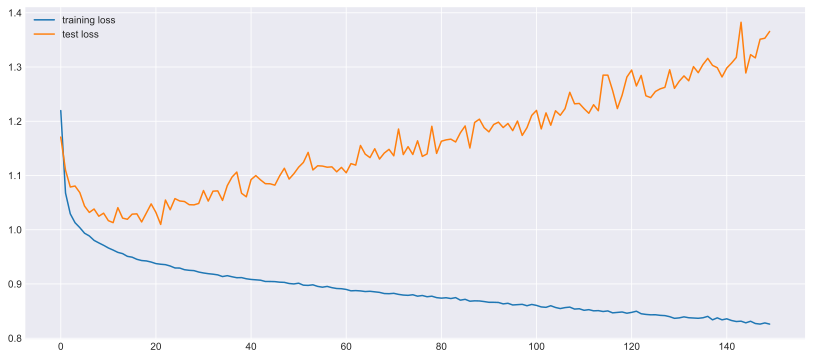

In [57]:
fig, axes = plt.subplots(figsize = (14,6))

axes.plot(result.history['loss'], label = 'training loss')
axes.plot(result.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

Overfitting is in action!!!

In [59]:
# first T + 1 vals are not predictable taking into account the differencing we performed 

train_idx[:T+1] = False

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

pred_train = scaler.inverse_transform(pred_train).flatten()
pred_test = scaler.inverse_transform(pred_test).flatten()

1/1 [==============================] - 0s 21ms/step


In [61]:
# store the predictions in the df

df_sb.loc[train_idx, 'Dtrain_pred'] = pred_train
df_sb.loc[test_idx, 'Dtest_pred'] = pred_test

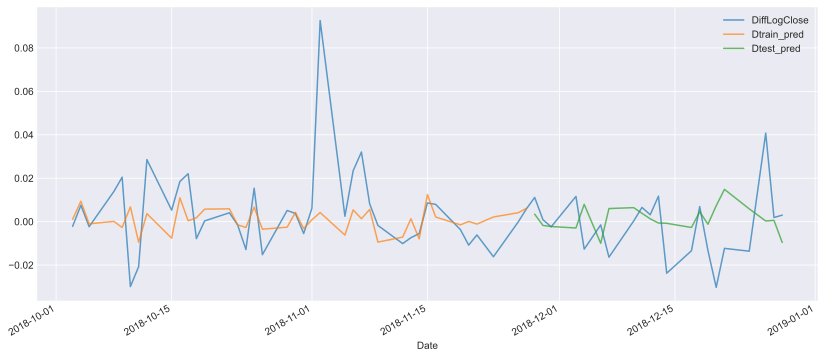

In [65]:
# Plot the predictions vs actual data 

fig, axes = plt.subplots(figsize = (14,6))

cols = ['DiffLogClose', 'Dtrain_pred', 'Dtest_pred']

df_sb[cols][-60:].plot(ax = axes, alpha = 0.7)

axes.grid()



Does not seem that much promising as we confirmed earlier that the model overfits!

In [67]:
# get un-differenced predictions 

df_sb['ShiftLogClose'] = df_sb['LogClose'].shift(1)
prev = df_sb['ShiftLogClose']

# last known train value 
last_train = train.iloc[-1]['LogClose']

# 1 - step stock price forecast 

df_sb.loc[train_idx, '1s_train_pred'] = prev[train_idx] + pred_train
df_sb.loc[test_idx, '1s_test_pred'] = prev[test_idx] + pred_test


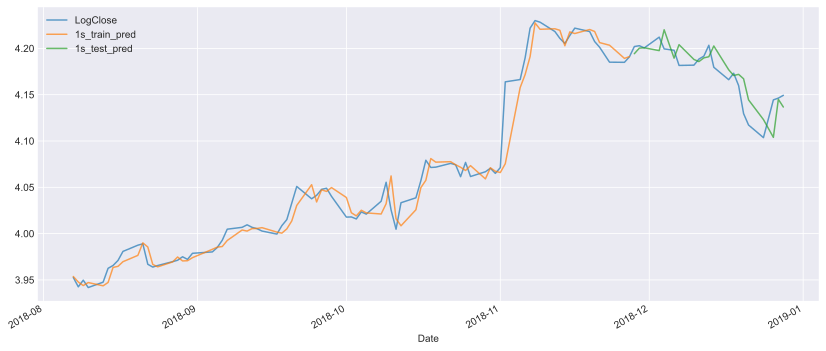

In [68]:
# plot 1-step forecasts 

fig, axes = plt.subplots(figsize = (14,6))

df_sb.iloc[-100:][['LogClose','1s_train_pred', '1s_test_pred']].plot(ax = axes, alpha = 0.7)

axes.grid()

Notice the lagged predictions of the model (more visible on the training set) which is not surprising given the data we fed into the ANN.

In [69]:
# multi-step incremental forecast 

ms_preds = []

# first test input 

last_x = X_test[0]

while len(ms_preds)< Ntest:
    
    pred = model.predict(last_x.reshape(1,-1))[0]

    # update the predictions list 

    ms_preds.append(pred)

    # make the new input 

    last_x = np.roll(last_x, -1)
    last_x[-1] = pred

1/1 [==============================] - 0s 31ms/step


In [75]:
# inverse scaling of multi-step predictions 

ms_preds = np.array(ms_preds)

ms_preds = scaler.inverse_transform(ms_preds).flatten()

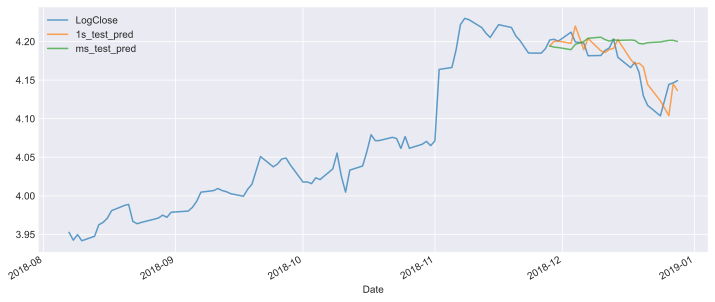

In [79]:
# add multi-step forecast to the dataframe and plot 

df_sb.loc[test_idx, 'ms_test_pred'] = last_train + np.cumsum(ms_preds)

fig, axes = plt.subplots(figsize = (12,5))

df_sb.iloc[-100:][['LogClose', '1s_test_pred', 'ms_test_pred']].plot(ax = axes, alpha = 0.7)

axes.grid()


In [92]:
# Prepare multi-output supervised dataset 

Tx = T
Ty = Ntest

X = []
Y = []

for t in range(len(series)- Tx- Ty + 1):

    x = series[t:t + Tx]
    X.append(x)

    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)


X = np.array(X)
Y = np.array(Y)
N = len(X)

print(f'X shape: {X.shape}', f'Y shape: {Y.shape}')

X shape: (2232, 10) Y shape: (2232, 21)


In [94]:
# train- test split, recall that the test set is the last row since it contrains our entire forecast horizon 

X_train_m, y_train_m  = X[:-1], Y[:-1]

X_test_m, y_test_m = X[-1:], Y[-1:] # last entry in the X and Y will be the test set

In [95]:
# Simple ANN

i = Input(shape = (Tx,))
x = Dense(32, activation = 'relu')(i)
x = Dense(Ty)(x)

mo_model = Model(i,x)

mo_model.compile(loss = 'mse', optimizer = 'adam')

mo_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_8 (Dense)             (None, 32)                352       
                                                                 
 dense_9 (Dense)             (None, 21)                693       
                                                                 
Total params: 1045 (4.08 KB)
Trainable params: 1045 (4.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
result_mo = mo_model.fit(X_train_m, y_train_m, epochs = 150, validation_data=(X_test_m, y_test_m))

Epoch 1/150
70/70 [==============================] - 1s 3ms/step - loss: 1.1578 - val_loss: 0.9917
Epoch 2/150
70/70 [==============================] - 0s 2ms/step - loss: 1.0667 - val_loss: 0.9814
Epoch 3/150
70/70 [==============================] - 0s 2ms/step - loss: 1.0355 - val_loss: 0.9769
Epoch 4/150
70/70 [==============================] - 0s 2ms/step - loss: 1.0191 - val_loss: 0.9754
Epoch 5/150
70/70 [==============================] - 0s 2ms/step - loss: 1.0101 - val_loss: 0.9765
Epoch 6/150
70/70 [==============================] - 0s 3ms/step - loss: 1.0042 - val_loss: 0.9754
Epoch 7/150
70/70 [==============================] - 0s 2ms/step - loss: 1.0004 - val_loss: 0.9740
Epoch 8/150
70/70 [==============================] - 0s 2ms/step - loss: 0.9975 - val_loss: 0.9758
Epoch 9/150
70/70 [==============================] - 0s 2ms/step - loss: 0.9952 - val_loss: 0.9776
Epoch 10/150
70/70 [==============================] - 0s 3ms/step - loss: 0.9934 - val_loss: 0.9754
Epoch 11/

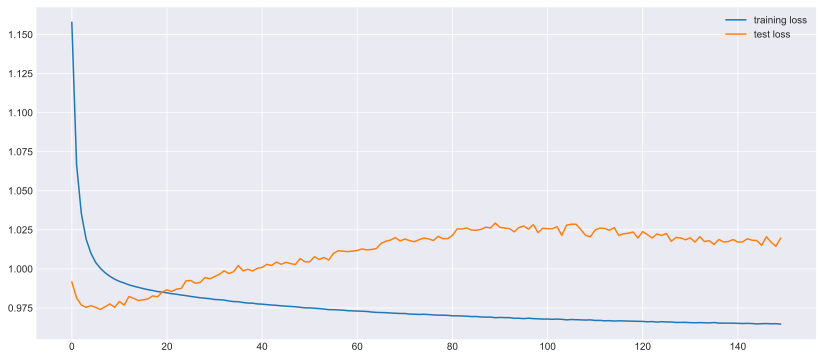

In [97]:
fig, axes = plt.subplots(figsize = (14,6))

axes.plot(result_mo.history['loss'], label = 'training loss')
axes.plot(result_mo.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

ANN still overfits! 

In [101]:
# get predictions 

mo_train_pred = mo_model.predict(X_train_m)
mo_test_pred = mo_model.predict(X_test_m)

mo_train_pred.shape, mo_test_pred.shape

1/1 [==============================] - 0s 20ms/step


((2231, 21), (1, 21))

In [103]:
mo_testp

array([ 0.00210657,  0.00163908,  0.0020651 ,  0.00166308,  0.0023822 ,
       -0.00054337,  0.00089125,  0.00156232, -0.00041735,  0.00190703,
        0.00190899,  0.00320874,  0.00134096,  0.00136839, -0.00028251,
       -0.0005944 ,  0.00038953, -0.00139831, -0.00063404,  0.00037901,
        0.00092196], dtype=float32)

In [104]:
# inverse x-form and un-difference 

mo_trainp = mo_train_pred[:,0]
mo_testp  = mo_test_pred[0]

# inverse x-from
mo_testp = scaler.inverse_transform(mo_testp.reshape(-1,1)).flatten()

# un-differenced test predictions for the LogClose 

df_sb.loc[test_idx, 'mo_test_pred'] = last_train + np.cumsum(mo_testp)

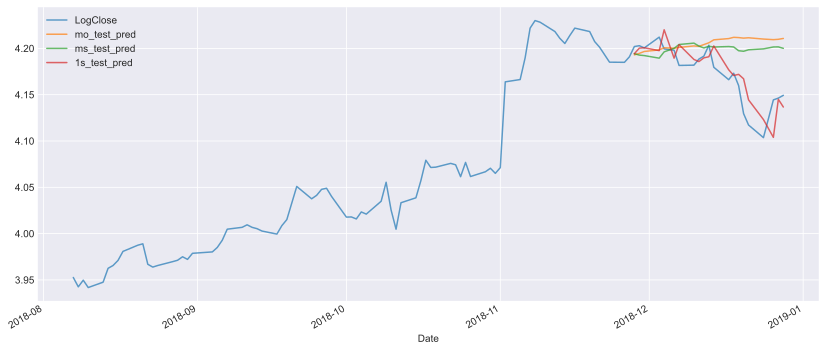

In [106]:
# And plot 

fig, axes = plt.subplots(figsize = (14,6))
cols = ['LogClose', 'mo_test_pred', 'ms_test_pred', '1s_test_pred']

df_sb.iloc[-100:][cols].plot(ax = axes, alpha = 0.7)

axes.grid()

In [108]:
# lets compare their MAPEs

test_lpass = df_sb.iloc[-Ntest:]['LogClose']

mape_ms = mean_absolute_percentage_error(test_lpass, df_sb.loc[test_idx, 'ms_test_pred'])
mape_mo = mean_absolute_percentage_error(test_lpass, df_sb.loc[test_idx, 'mo_test_pred'])

print(f'Multi-step method MAPE: {mape_ms:.3f}\n',f"Multi-output method MAPE: {mape_mo:.3f}")

Multi-step method MAPE: 0.008
 Multi-output method MAPE: 0.009


Turning the problem into a classification problem: 1-step binary classification of stock returns, is it up or down? 

In [138]:
# we have to re-label the outputs 

y_trainb = (y_train > 0) * 1
y_testb = (y_test > 0) * 1

In [139]:
# simple ANN model for classification, it is essentially the same model we used for 1-step forecast 

i = Input(shape = (T,))

x = Dense(32, activation = 'relu')(i)
x = Dense(1)(x)

cs_model = Model(i,x)

cs_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_14 (Dense)            (None, 32)                352       
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [140]:
cs_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), optimizer = 'adam', metrics = ['accuracy'])

In [141]:
result_cs = cs_model.fit(X_train, y_trainb, epochs = 150, validation_data = (X_test, y_testb))


Epoch 1/150
70/70 [==============================] - 1s 4ms/step - loss: 0.7184 - accuracy: 0.4984 - val_loss: 0.7131 - val_accuracy: 0.5238
Epoch 2/150
70/70 [==============================] - 0s 2ms/step - loss: 0.7014 - accuracy: 0.5007 - val_loss: 0.7059 - val_accuracy: 0.4762
Epoch 3/150
70/70 [==============================] - 0s 2ms/step - loss: 0.6951 - accuracy: 0.5065 - val_loss: 0.7012 - val_accuracy: 0.4762
Epoch 4/150
70/70 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5078 - val_loss: 0.6979 - val_accuracy: 0.4762
Epoch 5/150
70/70 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.5074 - val_loss: 0.6954 - val_accuracy: 0.4762
Epoch 6/150
70/70 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.5087 - val_loss: 0.6999 - val_accuracy: 0.4762
Epoch 7/150
70/70 [==============================] - 0s 2ms/step - loss: 0.6865 - accuracy: 0.5087 - val_loss: 0.6922 - val_accuracy: 0.4762
Epoch 8/150
7

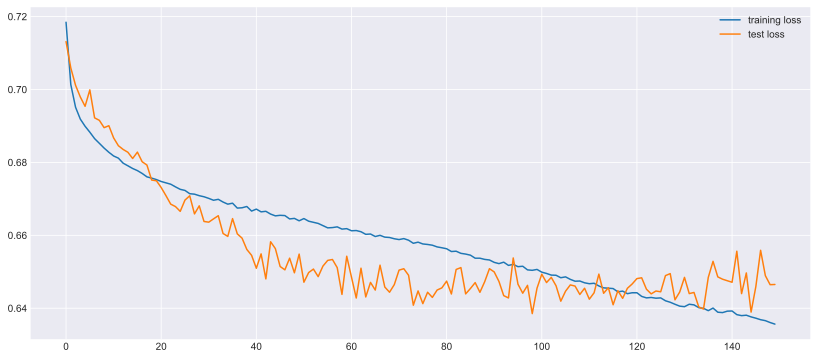

In [142]:
fig, axes = plt.subplots(figsize = (14,6))

axes.plot(result_cs.history['loss'], label = 'training loss')
axes.plot(result_cs.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

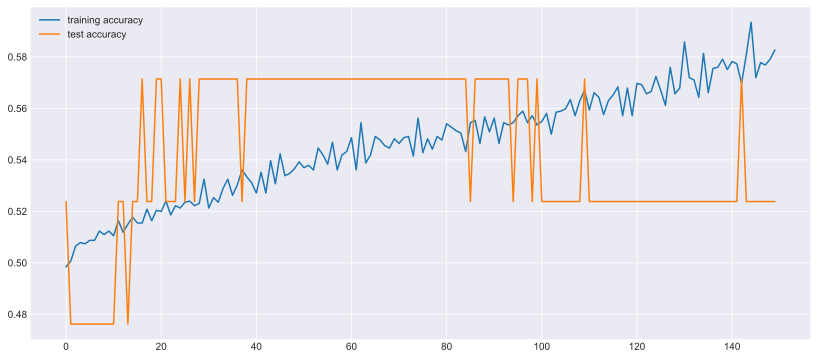

In [144]:
fig, axes = plt.subplots(figsize = (14,6))

axes.plot(result_cs.history['accuracy'], label = 'training accuracy')
axes.plot(result_cs.history['val_accuracy'], label = 'test accuracy')

axes.grid()
axes.legend()

Further checks and improvements that can be implemented: 

- Try without differencing and logging 
- More past lags to consider? 
- Walk forward valdiation to optimize the hyperparameters
- Better metrics for the classification task? (Recall, etc)